In [ ]:
!pip install openpyxl

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [34]:
img_size = 224

In [4]:
df_data = pd.read_csv("D:/archive/full_df.csv")
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
df_data2 = df_data.iloc[:, 1:7]
#df_data2['filepath'] = pd.Series(df_data['filepath'])
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [19]:
img_dir = "D:/archive/preprocessed_images"
df_left_dry_amd = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('dry age-related macular degeneration')]

df_rt_dry_amd = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('dry age-related macular degeneration')]

df_left_wet_amd = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('wet age-related macular degeneration')]

df_rt_wet_amd = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('wet age-related macular degeneration')]

df_amd_filenames = pd.concat([df_left_dry_amd['Left-Fundus'],df_rt_dry_amd['Right-Fundus'],df_rt_wet_amd['Right-Fundus'],df_left_wet_amd['Left-Fundus']])
len(df_amd_filenames)

526

In [20]:
df_left_gl = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('glaucoma')]

df_rt_gl = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('glaucoma')]

df_gl_filenames = pd.concat([df_left_gl['Left-Fundus'],df_rt_gl['Right-Fundus']])
len(df_gl_filenames)


494

In [21]:
df_left_dr = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('diabetic retinopathy')]

df_rt_dr = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('diabetic retinopathy')]

df_dr_filenames = pd.concat([df_left_dr['Left-Fundus'],df_rt_dr['Right-Fundus']])
len(df_dr_filenames)

50

(512, 512, 3)
260_right.jpg


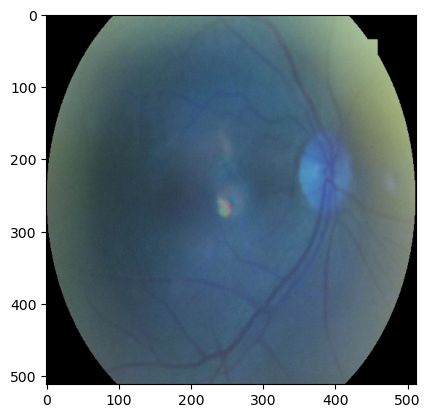

In [10]:
import cv2
img = df_amd_filenames[342]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

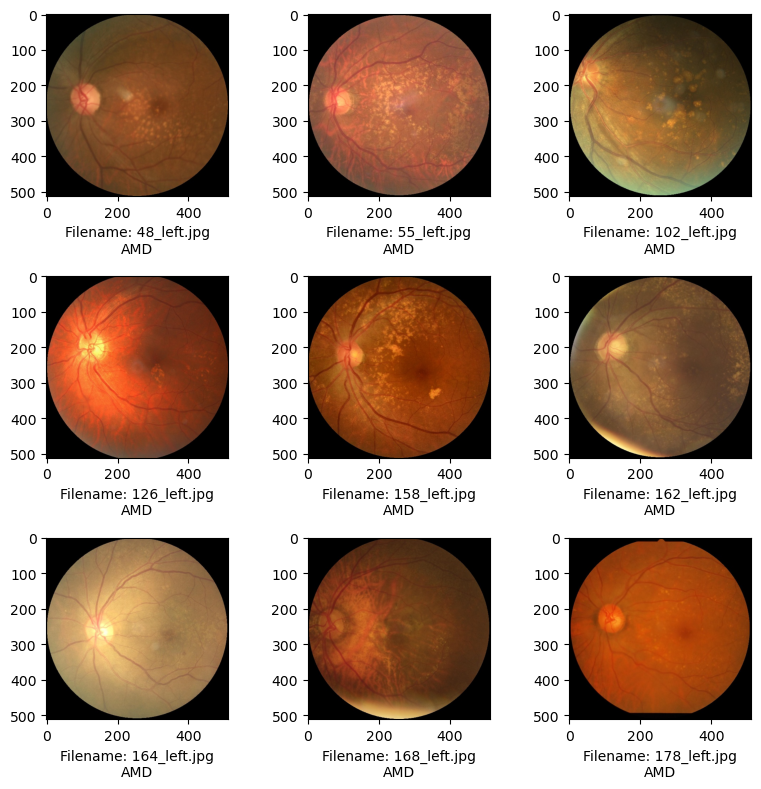

In [11]:
#create a grid for amd diseased eye
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_amd_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''AMD'.format(df_amd_filenames[i]))

plt.tight_layout() 

In [17]:
#gather normal images
df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
df_norm_filenames = pd.concat([df_left_norm['Left-Fundus'],df_rt_norm['Right-Fundus']])
df_norm_filenames

1           1_left.jpg
7           8_left.jpg
8           9_left.jpg
12         14_left.jpg
13         15_left.jpg
             ...      
6361    4642_right.jpg
6363    4644_right.jpg
6373    4660_right.jpg
6377    4671_right.jpg
6389    4689_right.jpg
Length: 5590, dtype: object

In [22]:
df_norm_filenames_random = df_norm_filenames.sample(n = 1070)
df_norm_filenames_random.head()
#reset the index
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0        2687_left.jpg
1         107_left.jpg
2       3038_right.jpg
3        460_right.jpg
4        2942_left.jpg
             ...      
1065     2454_left.jpg
1066    2852_right.jpg
1067    3111_right.jpg
1068     2796_left.jpg
1069    3250_right.jpg
Length: 1070, dtype: object

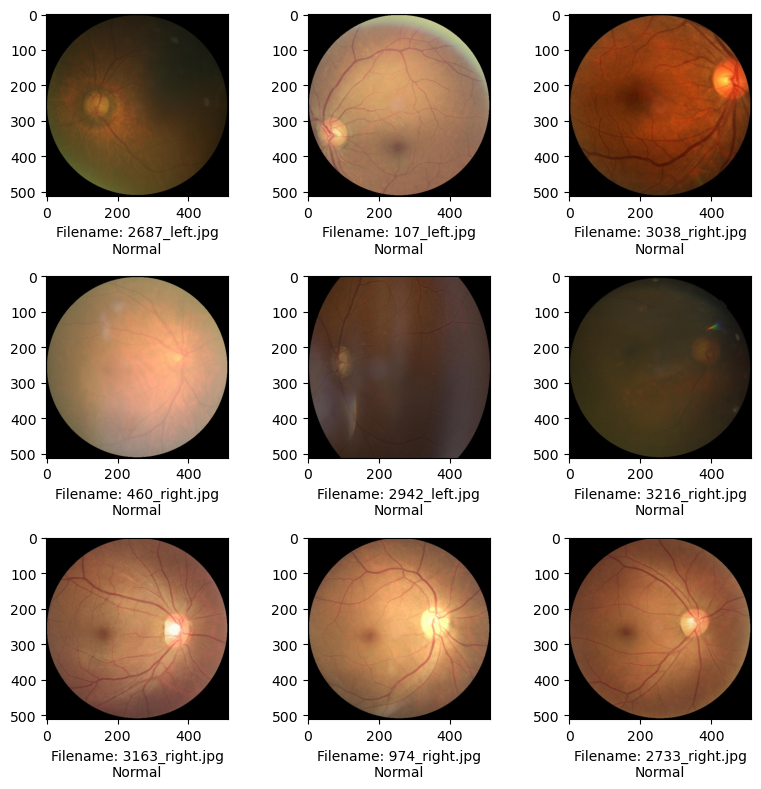

In [23]:
#create a grid for normal eyes
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout() 

In [24]:
df_amd_filenames = pd.DataFrame(df_amd_filenames, columns = ["filename"])
#df_amd_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_amd_filenames["label"] = "age-related-macular-disease"
df_amd_filenames.head()

,filename,label
39,48_left.jpg,age-related-macular-disease
46,55_left.jpg,age-related-macular-disease
85,102_left.jpg,age-related-macular-disease
106,126_left.jpg,age-related-macular-disease
132,158_left.jpg,age-related-macular-disease


In [25]:
df_gl_filenames = pd.DataFrame(df_gl_filenames, columns = ["filename"])
#df_gl_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_gl_filenames["label"] = "glaucoma"
df_gl_filenames.head()

,filename,label
129,153_left.jpg,glaucoma
141,167_left.jpg,glaucoma
510,583_left.jpg,glaucoma
986,1209_left.jpg,glaucoma
987,1210_left.jpg,glaucoma


In [26]:
df_dr_filenames = pd.DataFrame(df_dr_filenames, columns = ["filename"])
#df_dr_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_dr_filenames["label"] = "diabetic retinopathy"
df_dr_filenames.head()

,filename,label
52,64_left.jpg,diabetic retinopathy
55,67_left.jpg,diabetic retinopathy
57,71_left.jpg,diabetic retinopathy
201,234_left.jpg,diabetic retinopathy
272,311_left.jpg,diabetic retinopathy


In [27]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

,filename,label
0,2687_left.jpg,normal
1,107_left.jpg,normal
2,3038_right.jpg,normal
3,460_right.jpg,normal
4,2942_left.jpg,normal


In [41]:
df_combined = pd.concat([df_amd_filenames,df_gl_filenames,df_dr_filenames,df_norm_filenames_random,df_combined])

In [42]:
#Prior to feeding this organized set of cataract and normal images 
#we need to randomize the rows within so that when we train we will train from a random pool of samples.
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,1064_left.jpg,age-related-macular-disease
1,1353_right.jpg,glaucoma
2,1261_left.jpg,glaucoma
3,1345_right.jpg,glaucoma
4,808_right.jpg,age-related-macular-disease
...,...,...
5363,2510_left.jpg,normal
5364,2887_right.jpg,normal
5365,2842_left.jpg,normal
5366,1474_left.jpg,glaucoma


In [43]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

5368
4294
1074


In [44]:
#Here we will add some parameters that will perform some adjustment to the images.
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

In [45]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [46]:
#train set
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set, 
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))


#test set
test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 3436 validated image filenames belonging to 4 classes.
Found 858 validated image filenames belonging to 4 classes.
Found 1074 validated image filenames belonging to 4 classes.


In [49]:
import scipy
#The "next" command splits the generator data into two numpy arrays - one with image data and one with label data.
train_image_data, train_labels = next(train_generator)
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

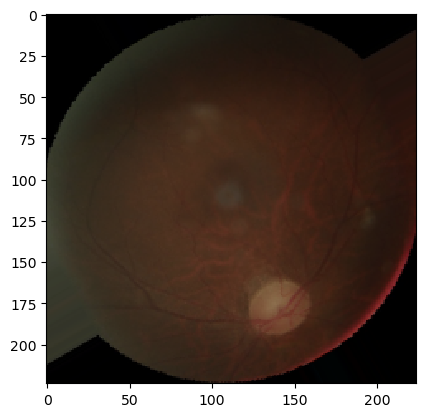

In [50]:
#single augmented image example
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

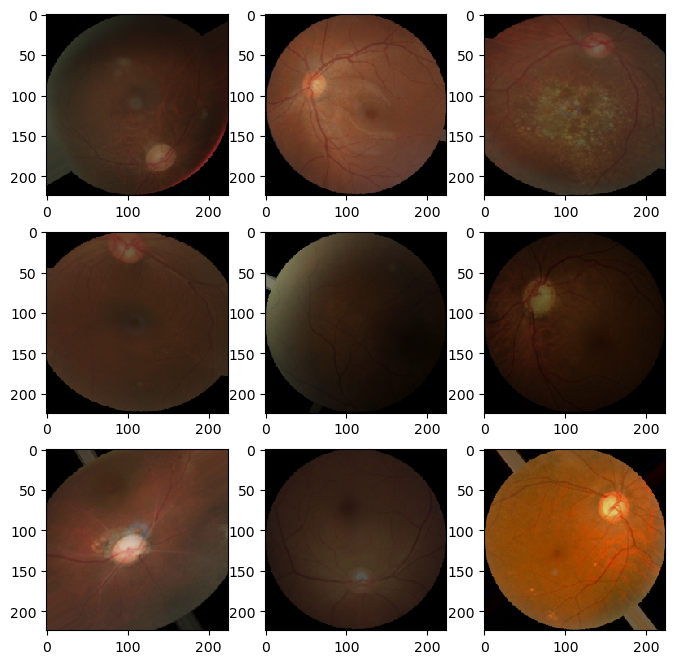

In [51]:
#grid of augmented images
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(train_image_data[i], interpolation='nearest')
    
plt.show() 

In [52]:
first_Mod = Sequential()

first_Mod.add(Conv2D(64,(3,3),activation='relu',input_shape=(224, 224, 3)))
first_Mod.add(Conv2D(64,(3,3),activation='relu'))
first_Mod.add(MaxPool2D(pool_size=(2,2)))
first_Mod.add(Dropout(0.2))

first_Mod.add(Conv2D(128,(3,3),activation='relu'))
first_Mod.add(Conv2D(128,(3,3),activation='relu'))
first_Mod.add(MaxPool2D(pool_size=(2,2)))
first_Mod.add(Dropout(0.2))

first_Mod.add(Flatten())
first_Mod.add(Dense(128,activation='relu'))
first_Mod.add(Dropout(0.2))
first_Mod.add(Dense(4,activation='softmax'))
first_Mod.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

first_Mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                        

In [53]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30
print(n_spe,n_val_steps)

107 26


In [ ]:
hist = first_Mod.fit(train_generator,batch_size=batch_size,epochs=n_epochs,verbose=1,validation_data=(test_generator))
score = first_Mod.evaluate(test_generator,batch_size=batch_size)
print('Test Loss',score[0])
print("Test Accuracy",score[1])

Epoch 1/30
108/108 [==============================] - 2089s 19s/step - loss: 1.0745 - accuracy: 0.5751 - val_loss: 0.9993 - val_accuracy: 0.6108
Epoch 2/30
108/108 [==============================] - 1945s 18s/step - loss: 0.9825 - accuracy: 0.5990 - val_loss: 0.9731 - val_accuracy: 0.6182
Epoch 3/30
108/108 [==============================] - 4811s 45s/step - loss: 0.9750 - accuracy: 0.6045 - val_loss: 1.0132 - val_accuracy: 0.6145
Epoch 4/30
108/108 [==============================] - 1502s 14s/step - loss: 0.9662 - accuracy: 0.6051 - val_loss: 0.9842 - val_accuracy: 0.6173
Epoch 5/30
108/108 [==============================] - 1650s 15s/step - loss: 0.9637 - accuracy: 0.6045 - val_loss: 0.9952 - val_accuracy: 0.6136
Epoch 6/30
108/108 [==============================] - 1674s 15s/step - loss: 0.9556 - accuracy: 0.6013 - val_loss: 0.9975 - val_accuracy: 0.6136
Epoch 7/30
108/108 [==============================] - 1428s 13s/step - loss: 0.9531 - accuracy: 0.6074 - val_loss: 0.9755 - val_ac